In [1]:
import time
import os
import subprocess
import sys
sys.path.insert(0,'..')
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_atac as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_atac as training_utils


from scipy import stats

2023-04-23 23:51:25.886074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 23:51:26.067309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-23 23:51:26.067342: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-23 23:51:26.994228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-1')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2023-04-21 19:55:54.242156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-21 19:55:54.242215: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-21 19:55:54.242237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2023-04-21 19:55:54.567277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 19:55:54.587363: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:42040
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-1


INFO:tensorflow:Initializing the TPU system: node-1


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
#with strategy.scope():

model = aformer.aformer(kernel_transformation='relu_kernel_transformation',
                        dropout_rate=0.30,
                        pointwise_dropout_rate=0.10,
                        input_length=262144,
                        output_length=2048,
                        final_output_length=1536,
                        num_heads=8,
                        numerical_stabilizer=0.0000001,
                        nb_random_features=256,
                        max_seq_length=2048,
                        rel_pos_bins=2048,
                        norm=True,
                        BN_momentum=0.90,
                        use_rot_emb = True,
                        use_mask_pos = False,
                        normalize = True,
                        num_transformer_layers=6,
                        inits_type="enformer_performer",
                        load_init=False,
                        stable_variant=False,
                        freeze_conv_layers=False,
                        filter_list_seq=[768,896,1024,1152,1280,1536],
                        filter_list_atac=[32,64],
                        output_heads=["human","mouse","rhesus","rat"],
                        learnable_PE=True)


test = tf.ones((1,262144,4)),tf.ones((1,65536,1))#,tf.ones((1,1,1536))
model(test,training=False)
print('ran test input')
#model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_mm_rm_rat_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-18_12:37:42/iteration_24/saved_model")
#model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-7_D-0.3_2023-04-13_15:39:43/final/saved_model")
model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-21_04:08:16/iteration_39/saved_model")
print('loaded weights')




/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


ran test input
loaded weights


In [4]:
def predict_on_batch(model, inputs):
    return model.predict_on_batch(inputs)

from deeplift import dinuc_shuffle
@tf.function
def contribution_input_grad(model, model_inputs, gradient_mask):
    seq, atac =model_inputs
    
    #seq_shuffled = dinuc_shuffle.dinuc_shuffle(sequence_one_hot, 1)[0]
    
    gradient_mask = tf.cast(gradient_mask,dtype=tf.float32)
    gradient_mask_mass = tf.reduce_sum(gradient_mask)

    with tf.GradientTape() as input_grad_tape:
        input_grad_tape.watch(seq)
        input_grad_tape.watch(atac)
        #input_grad_tape.watch(tf_acc)
        inputs = seq,atac#,tf_acc
        prediction, peaks_pred, embedding, att_matrices = model.predict_on_batch(inputs)
        
        prediction = tf.cast(prediction["human"],dtype=tf.float32)
        gradient_mask = tf.cast(gradient_mask,dtype=tf.float32)
        
        prediction_mask = tf.reduce_sum(gradient_mask *
                                        prediction) / gradient_mask_mass
        

    input_grads = input_grad_tape.gradient(prediction_mask, inputs)

    input_grads_seq = input_grads[0] 
    input_grads_atac = input_grads[1]

    seq_grads = tf.reduce_sum(input_grads_seq[0,:,:] * seq[0,:,:],
                              axis=1)

    atac_grads = input_grads_atac[0,:,] * atac[0,:,]

    return seq_grads, atac_grads, input_grads_seq[0,:,:], \
            prediction, att_matrices, embedding



In [5]:
def one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=0)

    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out


g=tf.random.Generator.from_seed(datetime.now().timestamp())
def deserialize_val(serialized_example,
                   input_length,
                   max_shift,
                   output_length_ATAC,
                   output_length,
                   crop_size,
                   output_res,
                   atac_mask,
                   log_atac,
                   g):
    """Deserialize bytes stored in TFRecordFile."""
    ## parse out feature map
    feature_map = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'atac': tf.io.FixedLenFeature([], tf.string),
        'tss_tokens': tf.io.FixedLenFeature([], tf.string),
        'peaks': tf.io.FixedLenFeature([], tf.string)
    }
    ### stochastic sequence shift and gaussian noise

    seq_shift=5
    stupid_random_seed = g.uniform([], 0, 10000000,dtype=tf.int32)
    input_seq_length = input_length + max_shift
    
    ## now parse out the actual data
    data = tf.io.parse_example(serialized_example, feature_map)
    sequence = one_hot(tf.strings.substr(data['sequence'],
                                 seq_shift,input_length))
    atac = tf.ensure_shape(tf.io.parse_tensor(data['atac'],
                                              out_type=tf.float32),
                           [output_length_ATAC,1])
    peaks = tf.ensure_shape(tf.io.parse_tensor(data['peaks'],
                                              out_type=tf.int32),
                           [output_length])
    peaks_crop = tf.slice(tf.expand_dims(peaks,axis=1),
                     [crop_size,0],
                     [output_length-2*crop_size,-1])
    
    atac_target = atac ## store the target

    masked_atac = atac * atac_mask
    
    random_shuffled_tokens= tf.random.experimental.stateless_shuffle(masked_atac, 
                                                                      seed=[1, stupid_random_seed])
    full_comb_mask = (1.0-atac_mask)*random_shuffled_tokens
    masked_atac = masked_atac + full_comb_mask
    
    if log_atac: 
        masked_atac = tf.math.log1p(masked_atac)
        
    diff = tf.math.sqrt(tf.nn.relu(masked_atac - 100.0 * tf.ones(masked_atac.shape)))
    masked_atac = tf.clip_by_value(masked_atac, clip_value_min=0.0, clip_value_max=100.0) + diff
        
    atac_out = tf.reduce_sum(tf.reshape(atac_target, [-1,32]),axis=1,keepdims=True)

    atac_out = tf.cast(tf.cast(atac_out,dtype=tf.float16),dtype=tf.float32) ### round to be consistent with Enformer
    diff = tf.math.sqrt(tf.nn.relu(atac_out - 2500.0 * tf.ones(atac_out.shape)))
    atac_out = tf.clip_by_value(atac_out, clip_value_min=0.0, clip_value_max=2500.0) + diff
    atac_out = tf.slice(atac_out,
                        [crop_size,0],
                        [output_length-2*crop_size,-1])

        
    tss_tokens = tf.ensure_shape(tf.io.parse_tensor(data['tss_tokens'],
                                              out_type=tf.int32),
                           [output_length-2*crop_size])
    tss_tokens=tf.expand_dims(tss_tokens,axis=1)
        
        
    return {'sequence': tf.ensure_shape(sequence,
                                        [input_length,4]),
            'atac': tf.ensure_shape(masked_atac,
                                    [output_length_ATAC,1]),
            'tss_tokens': tf.ensure_shape(tss_tokens,
                                      [output_length-crop_size*2,1]),
            'peaks': tf.ensure_shape(peaks_crop,
                                      [output_length-crop_size*2,1]),
            'target': tf.ensure_shape(atac_out,
                                      [output_length-crop_size*2,1])}

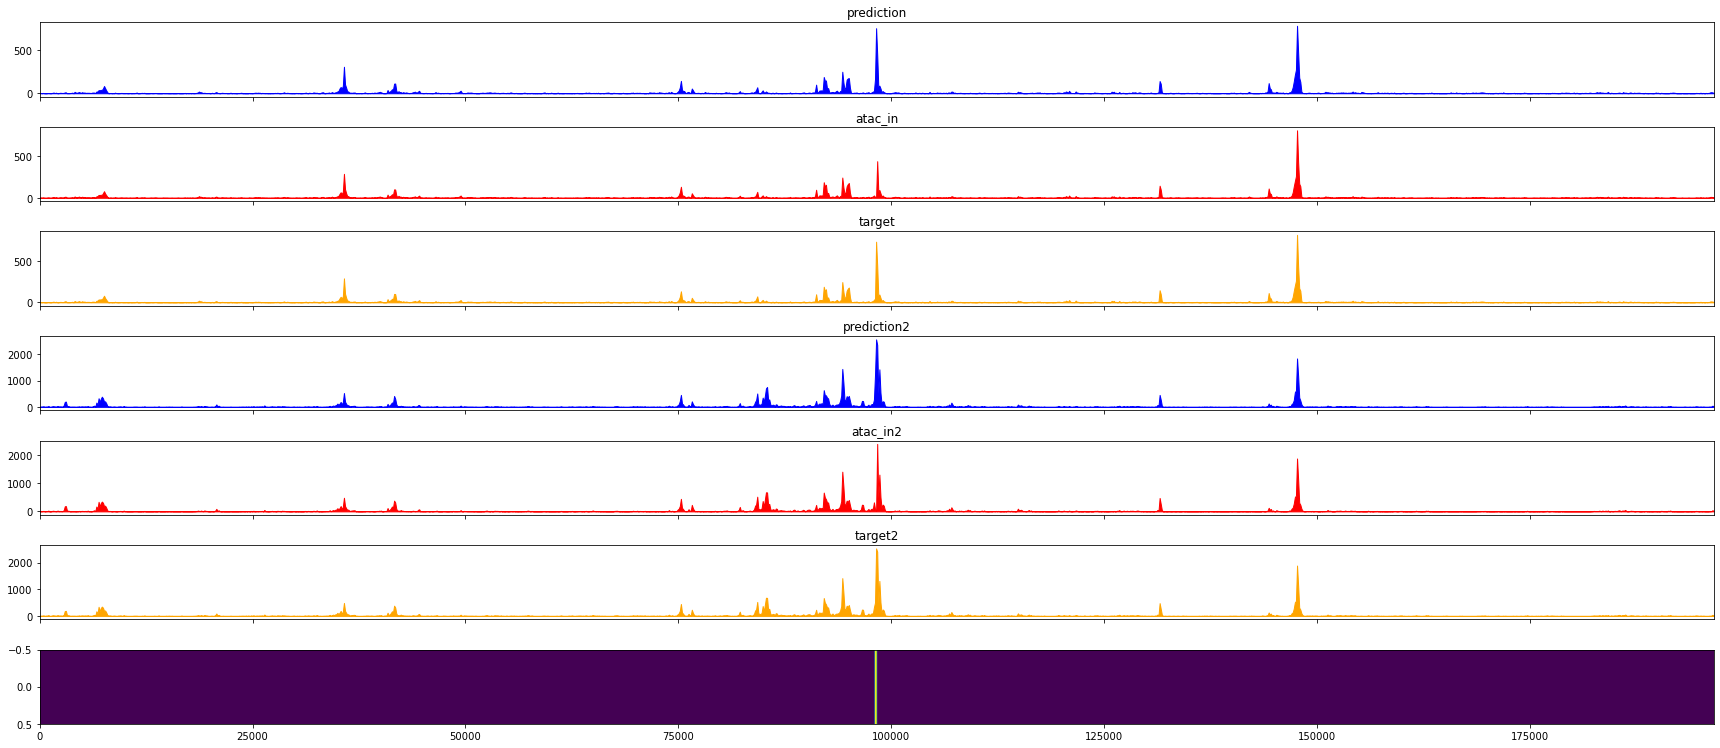

In [18]:
atac_mask = np.ones((2048,1))
for k in tf.range(1022,1024):
    atac_mask[k,0] = 0.0
#for k in tf.range(1582,1598):
#    atac_mask[k,0] = 0.0

atac_mask = tf.constant(atac_mask,dtype=tf.float32)

atac_mask = tf.reshape(tf.tile(atac_mask, [1,32]),[-1])
atac_mask = tf.expand_dims(atac_mask,axis=1)

filenames = ["gs://picard-testing-176520/genformer_atac_pretrain/262k/genformer_atac_pretrain_globalacc_conv_rpgc_SINGLE/HG_Jurkat.chr12-9764927-9764966.CD69_promoter.tfr",
             "gs://picard-testing-176520/genformer_atac_pretrain/262k/genformer_atac_pretrain_globalacc_conv_rpgc_SINGLE/HG_Jurkat_stim.chr12-9764927-9764966.CD69_promoter.tfr"]
             
    
seqs_out = []
seq_grads_out = []
atacs_out = []
predictions_out = []
targets_out = []
full_grads_out = []
for file in filenames:
    g = tf.random.Generator.from_seed(datetime.now().timestamp())
    dataset = tf.data.TFRecordDataset(file,
                                      compression_type='ZLIB',
                                      num_parallel_reads=4)
    dataset = dataset.map(lambda record: deserialize_val(record,
                                                         262144,
                                                         10,
                                                             65536,
                                                         2048,
                                                         256,
                                                         128,
                                                         atac_mask,
                                                            True,g),
                          deterministic=False,
                          num_parallel_calls=4)
    dataset=dataset.batch(1)
    iter_test = iter(dataset)
    test = next(iter_test)
    inputs = test['sequence'], \
                test['atac']#, \
                    #test['global_acc']

    mask = np.zeros((1,1536,1))
    for k in range(1536):
        if k in range(766,769):
            mask[0,k,0]=1

    seq_grads, atac_grads,full_grads, prediction,att_matrices,embedding = contribution_input_grad(model,inputs, mask)
    
    atacs_out.append(test['atac'])
    predictions_out.append(prediction)
    targets_out.append(test['target'])
    seq_grads_out.append(seq_grads)
    full_grads_out.append(full_grads)
    
def plot_tracks(tracks, peaks, start, end, height=1.5):
    fig, axes = plt.subplots(len(tracks)+1, 1, figsize=(24, height * (len(tracks)+1)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
        ax.set_title(title)
    axes[-1].imshow(peaks, aspect = "auto", cmap="viridis")
    plt.tight_layout()

#for idx, atacs in enumerate(atacs_out):
    
tracks={'prediction': (predictions_out[0][0,:,0],'blue'),
        'atac_in': (tf.reduce_sum(tf.reshape((tf.math.exp(atacs_out[0][0,:,0])-1.0), [2048,32]),axis=1)[256:-256],'red'),
        'target': (targets_out[0][0,:,0],'orange'),
        #'prediction1': (predictions_out[1][0,:,0],'blue'),
        #'atac_in1': (tf.reduce_sum(tf.reshape(atacs_out[1][0,:,0], [2048,32]),axis=1)[256:-256],'red'),
        #'target1': (targets_out[1][0,:,0],'orange'),
        'prediction2': (predictions_out[1][0,:,0],'blue'),
        'atac_in2': (tf.reduce_sum(tf.reshape((tf.math.exp(atacs_out[1][0,:,0])-1.0), [2048,32]),axis=1)[256:-256],'red'),
        'target2': (targets_out[1][0,:,0],'orange')}
        

atac_mask_expanded = (1.0 - tf.transpose(tf.slice(tf.expand_dims(tf.reshape(tf.tile(atac_mask,[1,4]),[-1]),axis=1),
         [32768,0],[196608,-1])))
plot_tracks(tracks, atac_mask_expanded,0,196608)

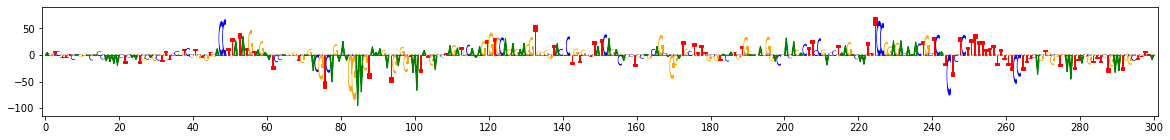

<AxesSubplot:>

In [19]:
##### import modisco.visualization
from modisco.visualization import viz_sequence


viz_sequence.plot_weights((((tf.expand_dims(seq_grads_out[0],axis=1) - tf.reduce_mean(full_grads_out[0],axis=1,keepdims=True)) * test['sequence'][0,:,:4]))[130922:131222,:], 
                          subticks_frequency=20) 

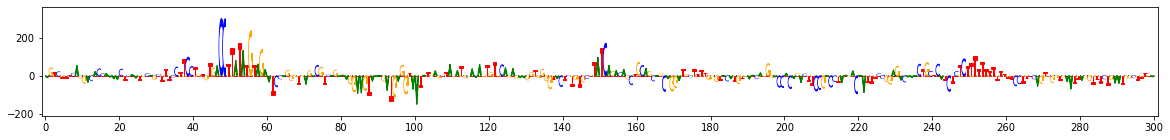

<AxesSubplot:>

In [20]:
##### import modisco.visualization
from modisco.visualization import viz_sequence
#- tf.reduce_mean(full_grads_out[1], axis=1,keepdims=True)
viz_sequence.plot_weights((((tf.expand_dims(seq_grads_out[1],axis=1) -  tf.reduce_mean(full_grads_out[1],axis=1,keepdims=True)) * test['sequence'][0,:,:4]))[130922:131222,:], 
                          subticks_frequency=20) 

In [48]:
full_grads_out[1]

<tf.Tensor: shape=(262144, 4), dtype=float32, numpy=
array([[ 0.00473022,  0.0009079 , -0.03662109,  0.00205994],
       [-0.01074219, -0.05175781, -0.02636719,  0.06445312],
       [-0.04589844,  0.02075195, -0.0098877 , -0.00160217],
       ...,
       [ 0.00457764, -0.01904297,  0.00970459,  0.00020981],
       [-0.00683594, -0.01257324,  0.01599121, -0.00531006],
       [-0.00057602, -0.01013184, -0.00500488,  0.01794434]],
      dtype=float32)>

In [50]:
(tf.expand_dims(seq_grads_out[1],axis=1)) / (tf.norm(full_grads_out[1],axis=1,keepdims=True))

<tf.Tensor: shape=(262144, 1), dtype=float32, numpy=
array([[ 0.05568317],
       [ 0.7372116 ],
       [ 0.4040647 ],
       ...,
       [ 0.2094173 ],
       [-0.5687375 ],
       [ 0.8458722 ]], dtype=float32)>

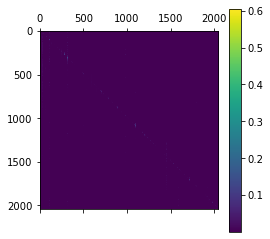

NameError: name 'seq_grad' is not defined

In [57]:
all_arrs=[]
for idx in range(6):
    k_1,q_1 = att_matrices['layer_' + str(idx)]
    
    for i in range(0,8):
        temp = tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(144.0))
        all_arrs.append(tf.expand_dims(temp,axis=0))
        #window_center = tf.reduce_sum(temp[794:799,:],axis=0)
        #print(window_center.shape)
        #promoter_att_unstim.append(temp)
        #plt.matshow(temp)
        #plt.colorbar()
        #plt.show()
        
    
        
all_arrs_concat = tf.concat(all_arrs, axis=0)
mean_att = tf.reduce_mean(all_arrs_concat,axis=0).numpy()
plt.matshow(mean_att)
plt.colorbar()
plt.show()

att_arr = tf.reduce_sum(mean_att[876:894,:],axis=0).numpy()

tracks={'seq_grad': (seq_grad, 'indianred'),
        'att_score': (np.log1p(att_arr), 'forestgreen'),
        'atac': (tf.reduce_sum(tf.reshape(test['atac'][0,:,:], [1536,32]),axis=1), 'forestgreen')}

def plot_tracks(tracks, peaks, start, end, height=1.5):
  fig, axes = plt.subplots(len(tracks)+1, 1, figsize=(24, height * (len(tracks)+1)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  axes[-1].imshow(peaks, aspect = "auto", cmap="viridis")
  plt.tight_layout()
    
    
#fig,ax = plt.subplots(figsize=(24, 1.5))
peaks = tf.concat([tf.zeros((1,320),dtype=tf.int32), test['peaks'][:,:,0], tf.zeros((1,320),dtype=tf.int32)],axis=1)
peaks_expand=tf.expand_dims(tf.reshape(tf.transpose(tf.tile(peaks,[128,1])),[-1]),axis=0)
#ax.imshow(peaks, aspect = "auto", cmap="viridis")


plot_tracks(tracks,peaks_expand, 0,196608)

In [59]:
start = 48688317
chrom = "chrX"

def write_bg(input_arr,out_file_name):
    out_file = open(out_file_name, 'w')
    for k, value in enumerate(input_arr):
        start_interval = k * 128 + start
        end_interval = (k+1) * 128 + start

        line = [str(chrom),
                str(start_interval), str(end_interval),
                str(value)]
        
        out_file.write('\t'.join(line) + '\n')
    out_file.close()
    
write_bg(att_arr,
         'gata1_hdac6_attention.bedgraph')
write_bg(tf.reduce_sum(tf.reshape(tf.abs(seq_grads), [1536,128]),axis=1).numpy(),
         'gata1_hdac6_seq_grad.bedgraph')
write_bg(tf.reduce_sum(tf.reshape(tf.abs(atac_grads), [1536,32]),axis=1).numpy(),
         'gata1_hdac6_atac_grad.bedgraph')

In [93]:
atac_mask = np.ones((1536,1))
for k in tf.range(533,548):
    atac_mask[k,0] = 0.0
    
atac_mask = tf.constant(atac_mask,dtype=tf.float32)

atac_mask = tf.reshape(tf.tile(atac_mask, [1,32]),[-1])
atac_mask = tf.expand_dims(atac_mask,axis=1)
print(atac_mask.shape)

filename = "gs://picard-testing-176520/genformer_atac_pretrain/genformer_atac_pretrain_globalacc_conv_rpgc_holdout_SINGLE/HG_K562.chr14-75278735-75278969.FOS_promoter.tfr"

g = tf.random.Generator.from_seed(datetime.now().timestamp())
dataset = tf.data.TFRecordDataset(filename,
                                  compression_type='ZLIB',
                                  num_parallel_reads=4)
dataset = dataset.map(lambda record: deserialize_val(record,
                                                     196608,
                                                     10,
                                                         49152,
                                                     1536,
                                                     320,
                                                     128,
                                                     atac_mask,
                                                        True, True),
                      deterministic=False,
                      num_parallel_calls=4)
dataset=dataset.batch(1)
iter_test = iter(dataset)
test = next(iter_test)
inputs = test['sequence'], \
            test['atac']#, \
                #test['global_acc']

mask = np.zeros((1,896,1))
for k in range(896):
    if k in range(445,452):
        mask[0,k,0]=1

seq_grads, atac_grads,prediction,att_matrices,embedding = contribution_input_grad(model,inputs, mask)


(49152, 1)


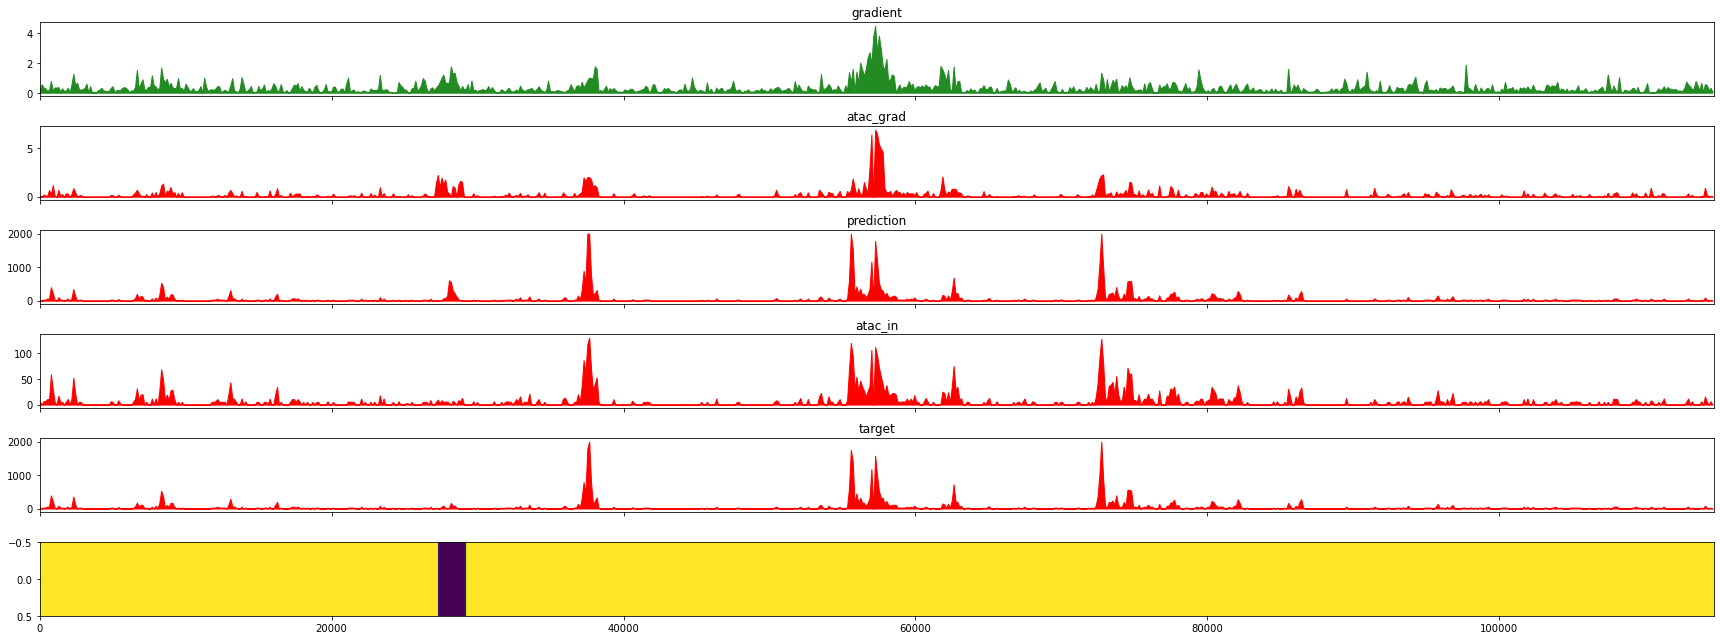

In [94]:

def plot_tracks(tracks, peaks, start, end, height=1.5):
  fig, axes = plt.subplots(len(tracks)+1, 1, figsize=(24, height * (len(tracks)+1)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  axes[-1].imshow(peaks, aspect = "auto", cmap="viridis")
  plt.tight_layout()


seq_grad = tf.math.abs(tf.reduce_sum(tf.reshape(seq_grads, [1536,128]),axis=1))[320:-320]
atac_grad = tf.math.abs(tf.reduce_sum(tf.reshape(atac_grads,[1536,32]),axis=1))[320:-320]
tracks={'gradient': (np.log(1.0+seq_grad), 'forestgreen'),
        'atac_grad': (np.log(1.0+atac_grad),'red'),
        'prediction': (np.minimum(2000,prediction[0,:,0]),'red'),
        'atac_in': (tf.reduce_sum(tf.reshape(test['atac'][0,:,0], [1536,32]),axis=1)[320:-320],'red'),
        'target': (np.minimum(2000,test['target'][0,:,0]),'red')}


atac_mask_expanded = tf.transpose(tf.slice(tf.expand_dims(tf.reshape(tf.tile(atac_mask,[1,4]),[-1]),axis=1),
         [40960,0],[114688,-1]))
plot_tracks(tracks, atac_mask_expanded,0,114608)

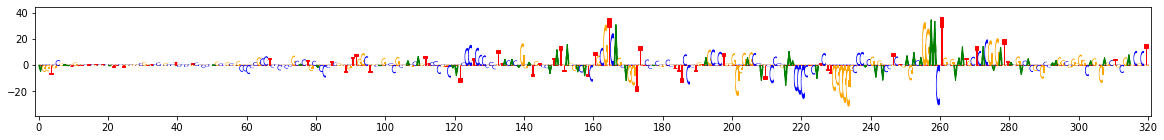

<AxesSubplot:>

In [20]:
##### import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4])[97820:98140,:],
                          subticks_frequency=20)

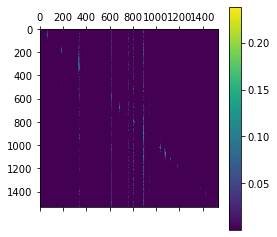

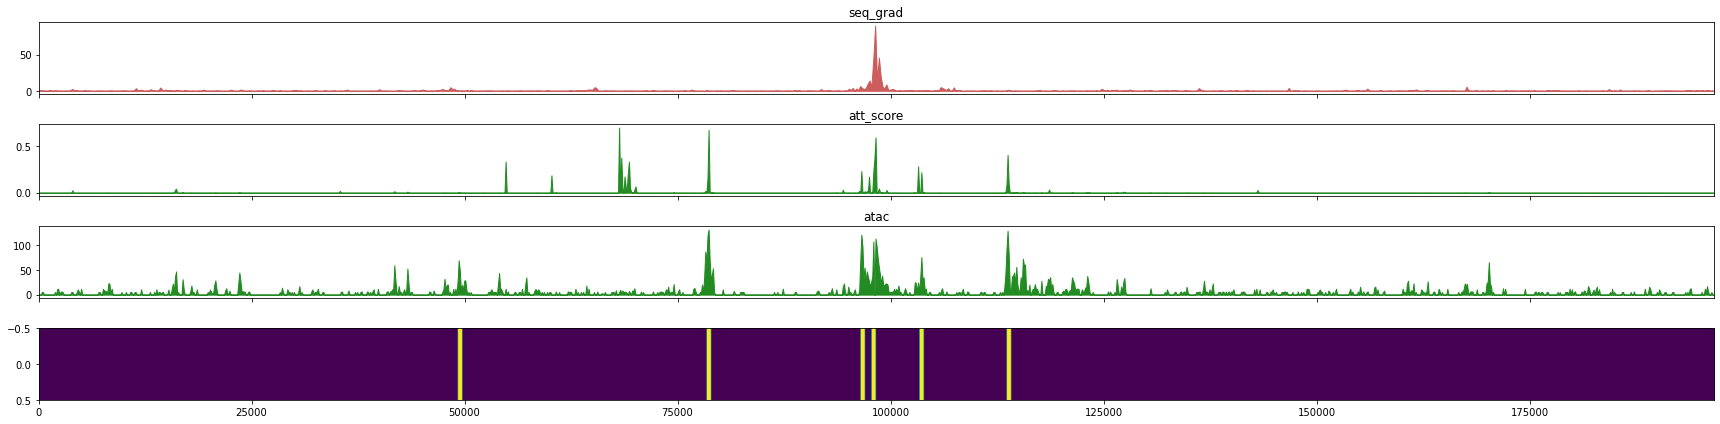

In [95]:
all_arrs=[]
for idx in range(6):
    k_1,q_1 = att_matrices['layer_' + str(idx)]
    
    for i in range(0,8):
        temp = tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(64.0))
        all_arrs.append(tf.expand_dims(temp,axis=0))
        #window_center = tf.reduce_sum(temp[794:799,:],axis=0)
        #print(window_center.shape)
        #promoter_att_unstim.append(temp)
        #plt.matshow(temp)
        #plt.colorbar()
        #plt.show()
        
    
        
all_arrs_concat = tf.concat(all_arrs, axis=0)
mean_att = tf.reduce_mean(all_arrs_concat,axis=0).numpy()
plt.matshow(mean_att)
plt.colorbar()
plt.show()

att_arr = tf.reduce_sum(mean_att[765:772,:],axis=0).numpy()

tracks={'seq_grad': (seq_grad, 'indianred'),
        'att_score': (att_arr, 'forestgreen'),
        'atac': (tf.reduce_sum(tf.reshape(test['atac'][0,:,:], [1536,32]),axis=1), 'forestgreen')}

def plot_tracks(tracks, peaks, start, end, height=1.5):
  fig, axes = plt.subplots(len(tracks)+1, 1, figsize=(24, height * (len(tracks)+1)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  axes[-1].imshow(peaks, aspect = "auto", cmap="viridis")
  plt.tight_layout()
    
    
#fig,ax = plt.subplots(figsize=(24, 1.5))
peaks = tf.concat([tf.zeros((1,320),dtype=tf.int32), test['peaks'][:,:,0], tf.zeros((1,320),dtype=tf.int32)],axis=1)
peaks_expand=tf.expand_dims(tf.reshape(tf.transpose(tf.tile(peaks,[128,1])),[-1]),axis=0)
#ax.imshow(peaks, aspect = "auto", cmap="viridis")


plot_tracks(tracks,peaks_expand, 0,196608)

In [31]:

filename = "gs://picard-testing-176520/genformer_atac_pretrain/genformer_atac_pretrain_globalacc_conv_rpgc_holdout_SINGLE/HG_BJ_U_DEEP_SENESCENCE.chr12-9764853-9765078.CD69.tfr"

g = tf.random.Generator.from_seed(datetime.now().timestamp())
dataset = tf.data.TFRecordDataset(filename,
                                  compression_type='ZLIB',
                                  num_parallel_reads=4)
dataset = dataset.map(lambda record: deserialize_val(record,
                                                     196608,
                                                     10,
                                                         49152,
                                                     1536,
                                                     320,
                                                     128,
                                                        False,
                                                        0.15,
                                                        True, True),
                      deterministic=False,
                      num_parallel_calls=4)
dataset=dataset.batch(1)
iter_test = iter(dataset)
test = next(iter_test)
inputs = test['sequence'], \
            test['atac'], \
                test['global_acc']

mask = np.zeros((1,896,1))
for k in range(896):
    if k in [447,448,449]:
        mask[0,k,0]=1

seq_grads, atac_grads, tf_acc_grads, prediction,att_matrices,embedding = contribution_input_grad(model,inputs,mask)



def plot_tracks(tracks, peaks, start,end, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(24, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
  #ax.imshow(peaks, aspect = "auto", cmap="viridis")

  plt.tight_layout()


seq_grad = tf.math.abs(tf.reduce_sum(tf.reshape(seq_grads, [1536,128]),axis=1))[320:-320]
atac_grad = tf.math.abs(tf.reduce_sum(tf.reshape(atac_grads,[1536,32]),axis=1))[320:-320]
tracks={'gradient': (np.log(1.0+seq_grad), 'forestgreen'),
        'atac_grad': (np.log(1.0+atac_grad),'red')}


plot_tracks(tracks, test['peaks'],0,114608)

TypeError: in user code:

    File "/tmp/ipykernel_6829/2637201755.py", line 7, in None  *
        True, True),

    TypeError: tf__deserialize_val() takes 10 positional arguments but 11 were given


In [ ]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(np.abs((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4] * tf.expand_dims(tf.reshape(tf.tile(atac_grads,[1,4]), [-1]), axis=1)))[98221:98341,:], 
                          subticks_frequency=20)

In [ ]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(np.abs((tf.expand_dims(seq_grads,axis=1) * test['sequence'][0,:,:4]))[98221:98341,:], 
                          subticks_frequency=20)

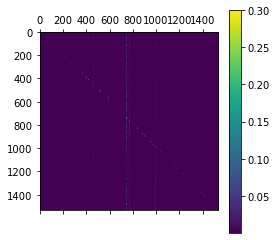

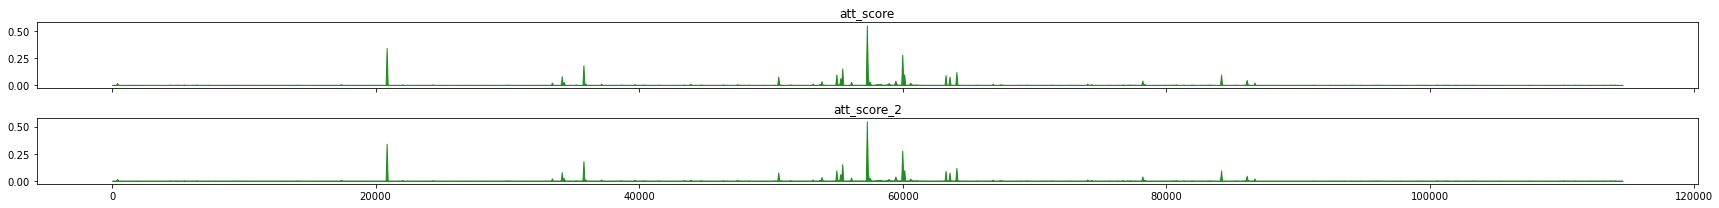

In [14]:
len(inside_checkpoint)

224

In [34]:
checkpoint_path="gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_mm_rm_rat_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-22_02:47:21/iteration_13"
inside_checkpoint=tf.train.list_variables(tf.train.latest_checkpoint(checkpoint_path))
reader = tf.train.load_checkpoint(checkpoint_path)


In [35]:
inside_checkpoint

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-0/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [5, 768, 768]),
 ('conv_tower/layer_with_weights-0/layer_with_weights-1/_layer/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [768]),
 ('conv_tower/layer_wit

In [10]:
from tensorflow.keras import initializers as inits
def get_initializers_enformer_performer(checkpoint_path,
                                        num_transformer_layers,
                                        stable_variant,
                                        learnable_PE):
    
    inside_checkpoint=tf.train.list_variables(tf.train.latest_checkpoint(checkpoint_path))
    reader = tf.train.load_checkpoint(checkpoint_path)
    
    initializers_dict = {'stem_conv_k': inits.Constant(reader.get_tensor('stem_conv/kernel/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_conv_b': inits.Constant(reader.get_tensor('stem_conv/bias/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_k': inits.Constant(reader.get_tensor('stem_res_conv/_layer/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_b': inits.Constant(reader.get_tensor('stem_res_conv/_layer/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_BN_g': inits.Constant(reader.get_tensor('stem_res_conv/_layer/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_BN_b': inits.Constant(reader.get_tensor('stem_res_conv/_layer/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_BN_m': inits.Constant(reader.get_tensor('stem_res_conv/_layer/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_BN_v': inits.Constant(reader.get_tensor('stem_res_conv/_layer/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'))}
    

    out_dict = {'stem_conv_atac_k': inits.Constant(reader.get_tensor('stem_conv_atac/kernel/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_conv_atac_b': inits.Constant(reader.get_tensor('stem_conv_atac/bias/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_atac_k': inits.Constant(reader.get_tensor('stem_res_conv_atac/_layer/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_atac_b': inits.Constant(reader.get_tensor('stem_res_conv_atac/_layer/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_atac_BN_g': inits.Constant(reader.get_tensor('stem_res_conv_atac/_layer/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_atac_BN_b': inits.Constant(reader.get_tensor('stem_res_conv_atac/_layer/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_atac_BN_m': inits.Constant(reader.get_tensor('stem_res_conv_atac/_layer/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE')),
                         'stem_res_conv_atac_BN_v': inits.Constant(reader.get_tensor('stem_res_conv_atac/_layer/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'))}
    initializers_dict.update(out_dict)
    
    
    out_dict = {'final_point_k': inits.Constant(reader.get_tensor('final_pointwise_conv/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE')),
                         'final_point_b': inits.Constant(reader.get_tensor('final_pointwise_conv/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE')),
                         'final_point_BN_g': inits.Constant(reader.get_tensor('final_pointwise_conv/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE')),
                         'final_point_BN_b': inits.Constant(reader.get_tensor('final_pointwise_conv/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE')),
                         'final_point_BN_m': inits.Constant(reader.get_tensor('final_pointwise_conv/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE')),
                         'final_point_BN_v': inits.Constant(reader.get_tensor('final_pointwise_conv/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'))}
    initializers_dict.update(out_dict)
    

    initializers_dict['stem_pool'] = inits.Constant(reader.get_tensor('stem_pool/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE'))
    initializers_dict['stem_pool_atac'] = inits.Constant(reader.get_tensor('stem_pool_atac/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE'))

    ## load in convolutional weights
    for i in range(6):
        var_name_stem = 'conv_tower/layer_with_weights-' + str(i) + '/layer_with_weights-' #0/moving_mean/_counter/.ATTRIBUTES/VARIABLE_VALUE'

        conv1_k = var_name_stem + '0/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE'
        conv1_b = var_name_stem + '0/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_g = var_name_stem + '0/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_b = var_name_stem + '0/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_m = var_name_stem + '0/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_v = var_name_stem + '0/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'
        
        conv2_k = var_name_stem + '1/_layer/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE'
        conv2_b = var_name_stem + '1/_layer/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_g = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_b = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_m = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_v = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'
        pool = var_name_stem + '2/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE'

        out_dict = {'conv1_k_' + str(i): inits.Constant(reader.get_tensor(conv1_k)),
                    'conv1_b_' + str(i): inits.Constant(reader.get_tensor(conv1_b)),
                    'BN1_g_' + str(i): inits.Constant(reader.get_tensor(BN1_g)),
                    'BN1_b_' + str(i): inits.Constant(reader.get_tensor(BN1_b)),
                    'BN1_m_' + str(i): inits.Constant(reader.get_tensor(BN1_m)),
                    'BN1_v_' + str(i): inits.Constant(reader.get_tensor(BN1_v)),
                    'conv2_k_' + str(i): inits.Constant(reader.get_tensor(conv2_k)),
                    'conv2_b_' + str(i): inits.Constant(reader.get_tensor(conv2_b)),
                    'BN2_g_' + str(i): inits.Constant(reader.get_tensor(BN2_g)),
                    'BN2_b_' + str(i): inits.Constant(reader.get_tensor(BN2_b)),
                    'BN2_m_' + str(i): inits.Constant(reader.get_tensor(BN2_m)),
                    'BN2_v_' + str(i): inits.Constant(reader.get_tensor(BN2_v))}

        out_dict['pool_' + str(i)] = inits.Constant(reader.get_tensor(pool))
        initializers_dict.update(out_dict)
        
        
    ## load in convolutional weights ATAC
    for i in range(2):
        var_name_stem = 'conv_tower_atac/layer_with_weights-' + str(i) + '/layer_with_weights-' #0/moving_mean/_counter/.ATTRIBUTES/VARIABLE_VALUE'

        conv1_k = var_name_stem + '0/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE'
        conv1_b = var_name_stem + '0/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_g = var_name_stem + '0/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_b = var_name_stem + '0/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_m = var_name_stem + '0/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE'
        BN1_v = var_name_stem + '0/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'
        
        conv2_k = var_name_stem + '1/_layer/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE'
        conv2_b = var_name_stem + '1/_layer/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_g = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_b = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/beta/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_m = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/moving_mean/.ATTRIBUTES/VARIABLE_VALUE'
        BN2_v = var_name_stem + '1/_layer/layer_with_weights-0/batch_norm/moving_variance/.ATTRIBUTES/VARIABLE_VALUE'
        pool = var_name_stem + '2/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE'

        out_dict = {'conv_at1_k_' + str(i): inits.Constant(reader.get_tensor(conv1_k)),
                    'conv_at1_b_' + str(i): inits.Constant(reader.get_tensor(conv1_b)),
                    'BN_at1_g_' + str(i): inits.Constant(reader.get_tensor(BN1_g)),
                    'BN_at1_b_' + str(i): inits.Constant(reader.get_tensor(BN1_b)),
                    'BN_at1_m_' + str(i): inits.Constant(reader.get_tensor(BN1_m)),
                    'BN_at1_v_' + str(i): inits.Constant(reader.get_tensor(BN1_v)),
                    'conv_at2_k_' + str(i): inits.Constant(reader.get_tensor(conv2_k)),
                    'conv_at2_b_' + str(i): inits.Constant(reader.get_tensor(conv2_b)),
                    'BN_at2_g_' + str(i): inits.Constant(reader.get_tensor(BN2_g)),
                    'BN_at2_b_' + str(i): inits.Constant(reader.get_tensor(BN2_b)),
                    'BN_at2_m_' + str(i): inits.Constant(reader.get_tensor(BN2_m)),
                    'BN_at2_v_' + str(i): inits.Constant(reader.get_tensor(BN2_v))}

        out_dict['pool_at_' + str(i)] = inits.Constant(reader.get_tensor(pool))
        initializers_dict.update(out_dict)
    
    
    initializers_dict['performer_encoder_LN_b'] = inits.Constant(reader.get_tensor("performer/layer_norm/layer_norm/beta/.ATTRIBUTES/VARIABLE_VALUE"))
    initializers_dict['performer_encoder_LN_g'] = inits.Constant(reader.get_tensor("performer/layer_norm/layer_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE"))
    
    for i in range(num_transformer_layers):
        var_name_stem = 'performer/layers/' + str(i) + '/' #0/moving_mean/_counter/.ATTRIBUTES/VARIABLE_VALUE'

        if not stable_variant:
            LN_b=var_name_stem + 'layer_norm/layer_norm/beta/.ATTRIBUTES/VARIABLE_VALUE'
            LN_g=var_name_stem + 'layer_norm/layer_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE'
            out_dict = {'LN_b' + str(i): inits.Constant(reader.get_tensor(LN_b)),
                        'LN_g' + str(i): inits.Constant(reader.get_tensor(LN_g))}
            initializers_dict.update(out_dict)
        
        SA_k=var_name_stem + "self_attention/key_dense_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE"
        SA_q=var_name_stem + "self_attention/query_dense_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE"
        SA_v=var_name_stem + "self_attention/value_dense_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE"
        SA_O=var_name_stem + "self_attention/output_dense_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE"
        
        FFN_narr_k=var_name_stem + "FFN/FFN_dense_narrow/kernel/.ATTRIBUTES/VARIABLE_VALUE"
        FFN_narr_b=var_name_stem + "FFN/FFN_dense_narrow/bias/.ATTRIBUTES/VARIABLE_VALUE"
        FFN_wide_k=var_name_stem + "FFN/FFN_dense_wide/kernel/.ATTRIBUTES/VARIABLE_VALUE"
        FFN_wide_b=var_name_stem + "FFN/FFN_dense_wide/bias/.ATTRIBUTES/VARIABLE_VALUE"
        FFN_LN_b=var_name_stem + "FFN/FFN_layer_norm/layer_norm/beta/.ATTRIBUTES/VARIABLE_VALUE"
        FFN_LN_g=var_name_stem + "FFN/FFN_layer_norm/layer_norm/gamma/.ATTRIBUTES/VARIABLE_VALUE"
    

        out_dict = {'SA_k' + str(i): inits.Constant(reader.get_tensor(SA_k)),
                    'SA_q' + str(i): inits.Constant(reader.get_tensor(SA_q)),
                    'SA_v' + str(i): inits.Constant(reader.get_tensor(SA_v)),
                    'SA_O' + str(i): inits.Constant(reader.get_tensor(SA_O)),
                    'FFN_narr_k' + str(i): inits.Constant(reader.get_tensor(FFN_narr_k)),
                    'FFN_narr_b' + str(i): inits.Constant(reader.get_tensor(FFN_narr_b)),
                    'FFN_wide_k' + str(i): inits.Constant(reader.get_tensor(FFN_wide_k)),
                    'FFN_wide_b' + str(i): inits.Constant(reader.get_tensor(FFN_wide_b)),
                    'FFN_LN_b' + str(i): inits.Constant(reader.get_tensor(FFN_LN_b)),
                    'FFN_LN_g' + str(i): inits.Constant(reader.get_tensor(FFN_LN_g))}

        initializers_dict.update(out_dict)
        
    if learnable_PE:
        out_dict = {'pos_embedding_learned': inits.Constant(reader.get_tensor('pos_embedding_learned/embeddings/.ATTRIBUTES/VARIABLE_VALUE'))}
        initializers_dict.update(out_dict)      
                    
    return initializers_dict

In [11]:

out = get_initializers_enformer_performer("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_mm_rm_rat_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-23_03:15:17/iteration_9",
                                        6,
                                        False,
                                        True)

In [16]:
out

{'stem_conv_k': <keras.initializers.initializers_v2.Constant at 0x7fd349f73c90>,
 'stem_conv_b': <keras.initializers.initializers_v2.Constant at 0x7fd349f73d50>,
 'stem_res_conv_k': <keras.initializers.initializers_v2.Constant at 0x7fd345fa48d0>,
 'stem_res_conv_b': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4f10>,
 'stem_res_conv_BN_g': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4150>,
 'stem_res_conv_BN_b': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4b50>,
 'stem_res_conv_BN_m': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4bd0>,
 'stem_res_conv_BN_v': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4f90>,
 'stem_conv_atac_k': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4450>,
 'stem_conv_atac_b': <keras.initializers.initializers_v2.Constant at 0x7fd345fa4fd0>,
 'stem_res_conv_atac_k': <keras.initializers.initializers_v2.Constant at 0x7fd34e223fd0>,
 'stem_res_conv_atac_b': <keras.initializers.initializ

In [32]:
 ('final_dense_peaks/human/layer_with_weights-0/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 384]),
 ('final_dense_peaks/human/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [1]),
 ('final_dense_peaks/human/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 1]),
 ('final_dense_peaks/mouse/layer_with_weights-0/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 384]),
 ('final_dense_peaks/mouse/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [1]),
 ('final_dense_peaks/mouse/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 1]),
 ('final_dense_peaks/rat/layer_with_weights-0/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 384]),
 ('final_dense_peaks/rat/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [1]),
 ('final_dense_peaks/rat/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 1]),
 ('final_dense_peaks/rhesus/layer_with_weights-0/_logit_linear/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 384]),
 ('final_dense_peaks/rhesus/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE',
  [1]),
 ('final_dense_peaks/rhesus/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
  [384, 1]),
 ('final_dense_profile/human/bias/.ATTRIBUTES/VARIABLE_VALUE', [1]),
 ('final_dense_profile/human/kernel/.ATTRIBUTES/VARIABLE_VALUE', [384, 1]),
 ('final_dense_profile/mouse/bias/.ATTRIBUTES/VARIABLE_VALUE', [1]),
 ('final_dense_profile/mouse/kernel/.ATTRIBUTES/VARIABLE_VALUE', [384, 1]),
 ('final_dense_profile/rat/bias/.ATTRIBUTES/VARIABLE_VALUE', [1]),
 ('final_dense_profile/rat/kernel/.ATTRIBUTES/VARIABLE_VALUE', [384, 1]),
 ('final_dense_profile/rhesus/bias/.ATTRIBUTES/VARIABLE_VALUE', [1]),
 ('final_dense_profile/rhesus/kernel/.ATTRIBUTES/VARIABLE_VALUE', [384, 1]),

203

In [37]:
reader.get_tensor("pos_embedding_learned/embeddings/.ATTRIBUTES/VARIABLE_VALUE")

array([[ 0.0164609 ,  0.02749372, -0.01542488, ...,  0.08125965,
        -0.10188409,  0.08790673],
       [ 0.03011785,  0.0357183 ,  0.0394407 , ..., -0.0041007 ,
        -0.05729758,  0.05099118],
       [ 0.02117763, -0.00183437, -0.01333619, ..., -0.01716687,
        -0.09254447,  0.06225032],
       ...,
       [-0.02391185,  0.02890328,  0.04887392, ..., -0.00027385,
        -0.00844594,  0.0621284 ],
       [ 0.0331138 ,  0.01647806,  0.00799965, ...,  0.00052548,
        -0.07112795,  0.08235224],
       [ 0.01340021,  0.03641171,  0.03264887, ...,  0.07121241,
        -0.03582776, -0.04955046]], dtype=float32)